In [5]:
import scanpy as sc
import numpy as np

In [6]:
import pandas as pd

In [7]:
import seaborn as sns

In [8]:
import matplotlib

In [9]:
import matplotlib.pyplot as plt

In [10]:
import milopy
import milopy.core as milo

In [28]:
# COPY REQUIRED FUNCTIONS HERE
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsm['X_diffmap'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

In [29]:
def write_deres(excel_path, adata, group, de_key):
    # writing results to excel file
    res_cat = ['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj']

    writer = pd.ExcelWriter(excel_path, engine='xlsxwriter')

    for g in group:
        d = {res_cat[0]: adata.uns[de_key][res_cat[0]][str(g)].tolist(),
             res_cat[1]: adata.uns[de_key][res_cat[1]][str(g)].tolist(),
             res_cat[2]: adata.uns[de_key][res_cat[2]][str(g)].tolist(),
             res_cat[3]: adata.uns[de_key][res_cat[3]][str(g)].tolist(),
             res_cat[4]: adata.uns[de_key][res_cat[4]][str(g)].tolist()
             }
        df = pd.DataFrame(data=d)
        df.to_excel(writer, sheet_name=str(g))

    writer.save()

In [30]:
import itertools

In [31]:
def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash'][z])
            if adata.obs['sample'][z] == 'BD1':
                rep[z] = rep_dict[z_arg]
            else:
                rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

In [32]:
def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep

In [33]:
def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood

In [34]:
def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal

In [35]:
def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

In [36]:
sc.set_figure_params(figsize=(4, 4), fontsize=20)
celltype_dict = {'Basophil': sns.color_palette('tab20', 20)[0],
                 'CCR7+ DC': sns.color_palette('tab20', 20)[2],
                 'CD4+ T cell': sns.color_palette('tab20', 20)[4],
                 'CD8+ T cell': sns.color_palette('tab20', 20)[6],
                 'Fibroblast': sns.color_palette('tab20', 20)[8],
                 'Fibroblast 2': sns.color_palette('tab20', 20)[9],
                 'Macrophage': sns.color_palette('tab20', 20)[10],
                 'Macrophage 2': sns.color_palette('tab20', 20)[11],
                 'Macrophage 3': sns.color_palette('tab20', 20)[13],
                 'Cd3+ Macrophage': sns.color_palette('tab20', 20)[17],
                 'Chil3+ Mac': 'xkcd:grey',
                 'Cx3cr1+ Mac': sns.color_palette('tab20', 20)[19],
                 'Mrc1+ Macrophage': sns.color_palette('tab20b', 20)[0],
                 'cDC2': sns.color_palette('tab20b', 20)[4],
                 'mt-Macrophage': sns.color_palette('tab20', 20)[14],
                 'NK cell': sns.color_palette('tab20', 20)[12],
                 'Neutrophil': sns.color_palette('tab20', 20)[16],
                 'Poorly classified': 'xkcd:light grey',
                 'Mixed': 'xkcd:light grey',
                 'Treg': sns.color_palette('tab20', 20)[1],
                 'Tumor cell': sns.color_palette('tab20', 20)[3],
                 'XCR1+ DC': sns.color_palette('tab20', 20)[5]}

In [37]:
sample_dict = {'Ctrl d8': sns.husl_palette(5)[0],
               'CPI hi d8': sns.husl_palette(5)[1], 'CPI lo d8': sns.husl_palette(5)[2],
               'CD40ag d8': sns.husl_palette(5)[3], 'TTx d8': sns.husl_palette(5)[4]}

In [38]:
adata_d8 = sc.read('/Users/anasuyadighe/Downloads/cpi_cd40_d8_refined.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [39]:
adata_d8.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,...,IR_VDJ_2_v_call,has_ir,nn_80,hashing,CD40ag d8,CPI hi d8,CPI lo d8,Ctrl d8,TTx d8,nn_refined
AAACGGGAGCTAGTCT-1-BD2,1701,7.439559,4351.0,8.378390,30.268904,41.714548,53.321076,70.144794,78.0,4.369448,...,NaN,True,CD4+ T cell,3,0.100572,0.181816,0.228663,0.328996,0.159953,CD4+ T cell
AAAGATGAGCGATAGC-1-BD2,1408,7.250636,3242.0,8.084254,32.973473,45.681678,55.953115,71.992597,147.0,4.997212,...,NaN,True,CD4+ T cell,3,0.089040,0.253088,0.260308,0.220529,0.177035,CD4+ T cell
AAAGCAAGTCACCCAG-1-BD2,2348,7.761745,7196.0,8.881419,26.417454,37.576431,49.402446,66.259033,200.0,5.303305,...,NaN,True,Treg,0,0.134281,0.096152,0.271935,0.307434,0.190198,Treg
AAAGTAGAGAGAACAG-1-BD2,915,6.820016,3832.0,8.251403,73.303758,76.409186,81.341336,89.170146,449.0,6.109248,...,NaN,None,Macrophage,1,0.144090,0.187718,0.203593,0.232874,0.231725,mt-Macrophage
AAAGTAGAGTGGGCTA-1-BD2,1838,7.516977,4305.0,8.367764,28.153310,40.092915,50.685250,66.922184,64.0,4.174387,...,NaN,None,NK cell,2,0.141425,0.166322,0.266373,0.243239,0.182640,NK cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCAGTGCAT-1-BD6,1476,7.297768,3937.0,8.278428,31.724663,41.122682,53.086106,72.085344,37.0,3.637586,...,NaN,None,Macrophage,0,0.221038,0.187455,0.163993,0.105628,0.321886,Macrophage 2
TTTGTCATCCCGGATG-1-BD6,1707,7.443078,5132.0,8.543446,33.008574,42.556508,54.618083,72.408418,99.0,4.605170,...,NaN,None,Macrophage,0,0.234366,0.172371,0.155956,0.107821,0.329486,Macrophage 2
TTTGTCATCGACAGCC-1-BD6,1946,7.574045,5771.0,8.660774,30.272050,41.050078,53.855484,70.542367,113.0,4.736198,...,NaN,None,Macrophage,3,0.250402,0.175666,0.176301,0.136666,0.260966,Macrophage 1
TTTGTCATCTAACGGT-1-BD6,1930,7.565793,5644.0,8.638525,33.185684,43.515237,54.872431,70.552799,74.0,4.317488,...,NaN,None,Macrophage,1,0.122828,0.260875,0.212458,0.143430,0.260409,Cx3cr1+ Macrophage


In [40]:
type_annot = adata_d8.obs['nn_80'].values.tolist()
for i in np.where(adata_d8.obs['nn_refined'] == 'cDC2')[0]:
    type_annot[i] = 'cDC2'

adata_d8.obs['celltype'] = type_annot

In [41]:
adata_d8

AnnData object with n_obs × n_vars = 8655 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'sample', 'sample_cond', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_

In [42]:
adata_d8 = adata_d8[np.where(np.sum(adata_d8.obsm['hash'], axis=1) > 0)]


In [43]:
adata_d8 = remove_recompute(adata_d8)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_11913/1760758028.py:3: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsm['X_diffmap'], adata.obsp, adata.uns
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cur

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


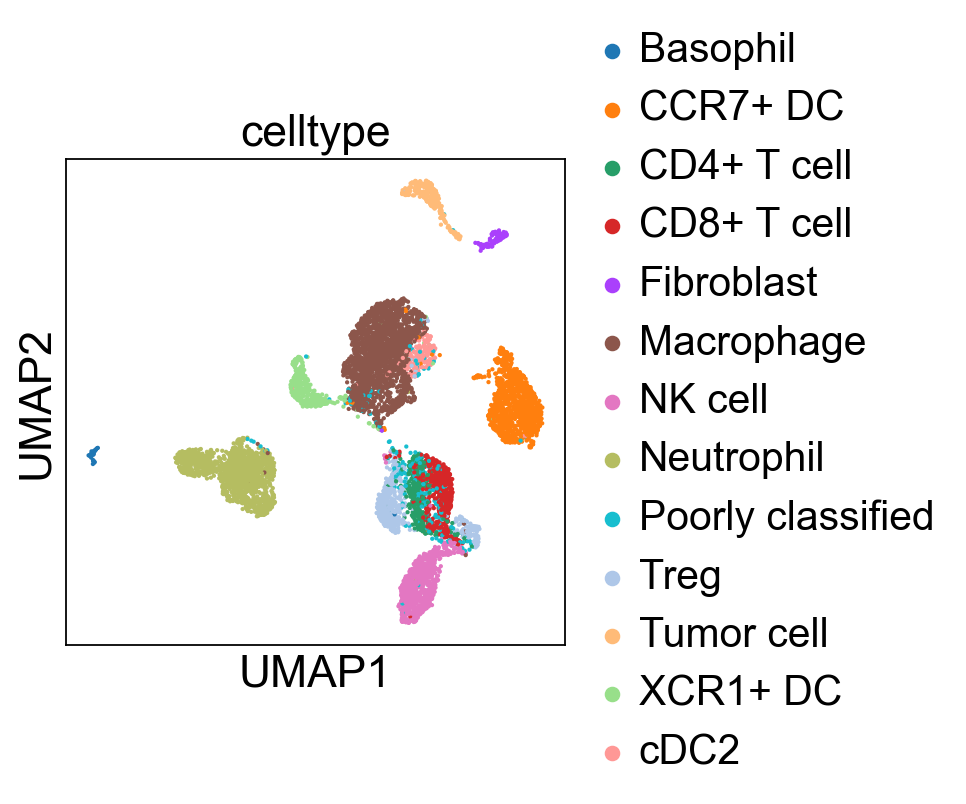

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


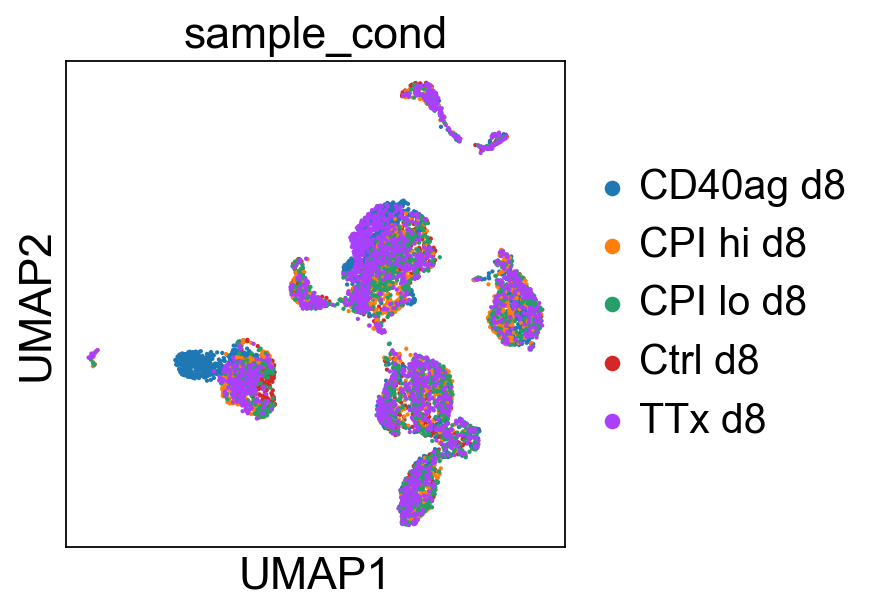

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


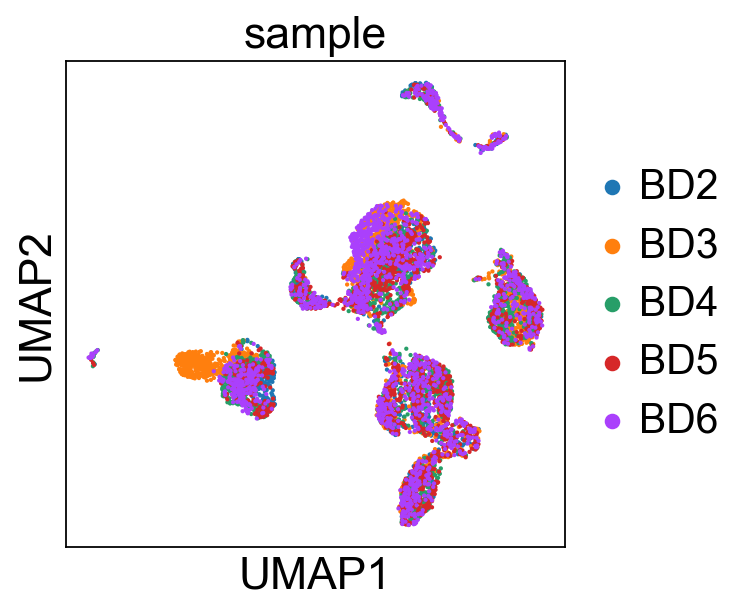

In [44]:
sc.pl.umap(adata_d8, color='celltype')
sc.pl.umap(adata_d8, color = 'sample_cond')
sc.pl.umap(adata_d8, color = 'sample')

In [49]:
ctrld8_ind = np.where(adata_d8.obs['sample'] == 'BD2')[0]

In [50]:
ctrld8_ind

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [54]:
d8_pairs = []
for g in np.arange(3, 7):
    next_ind = np.where(adata_d8.obs['sample'] == 'BD{}'.format(g))[0]
    adatas = adata_d8[np.concatenate((ctrld8_ind, next_ind)), :]
    adatas = remove_recompute(adatas)
    d8_pairs.append(adatas.copy())

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_9647/3464940285.py:3: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_9647/3464940285.py:3: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_9647/3464940285.py:3: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_9647/3464940285.py:3: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.

In [66]:
cpi_cd40 = d8_pairs[3]

In [91]:
adata_d8.obs['sample']

AAACGGGAGCTAGTCT-1-BD2    BD2
AAAGATGAGCGATAGC-1-BD2    BD2
AAAGCAAGTCACCCAG-1-BD2    BD2
AAAGTAGAGAGAACAG-1-BD2    BD2
AAAGTAGAGTGGGCTA-1-BD2    BD2
                         ... 
TTTGTCATCAGTGCAT-1-BD6    BD6
TTTGTCATCCCGGATG-1-BD6    BD6
TTTGTCATCGACAGCC-1-BD6    BD6
TTTGTCATCTAACGGT-1-BD6    BD6
TTTGTCATCTGGTTCC-1-BD6    BD6
Name: sample, Length: 8155, dtype: category
Categories (5, object): ['BD2', 'BD3', 'BD4', 'BD5', 'BD6']

TypeError: 'method' object is not subscriptable

In [103]:
adata_d8.obs['sample_cond']

AAACGGGAGCTAGTCT-1-BD2    Ctrl d8
AAAGATGAGCGATAGC-1-BD2    Ctrl d8
AAAGCAAGTCACCCAG-1-BD2    Ctrl d8
AAAGTAGAGAGAACAG-1-BD2    Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2    Ctrl d8
                           ...   
TTTGTCATCAGTGCAT-1-BD6     TTx d8
TTTGTCATCCCGGATG-1-BD6     TTx d8
TTTGTCATCGACAGCC-1-BD6     TTx d8
TTTGTCATCTAACGGT-1-BD6     TTx d8
TTTGTCATCTGGTTCC-1-BD6     TTx d8
Name: sample_cond, Length: 8155, dtype: category
Categories (5, object): ['CD40ag d8', 'CPI hi d8', 'CPI lo d8', 'Ctrl d8', 'TTx d8']

AAACGGGAGCTAGTCT-1-BD2    Ctrl d8
AAAGATGAGCGATAGC-1-BD2    Ctrl d8
AAAGCAAGTCACCCAG-1-BD2    Ctrl d8
AAAGTAGAGAGAACAG-1-BD2    Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2    Ctrl d8
                           ...   
TTTGTCATCAGTGCAT-1-BD6     TTx d8
TTTGTCATCCCGGATG-1-BD6     TTx d8
TTTGTCATCGACAGCC-1-BD6     TTx d8
TTTGTCATCTAACGGT-1-BD6     TTx d8
TTTGTCATCTGGTTCC-1-BD6     TTx d8
Name: sample_cond, Length: 8155, dtype: category
Categories (5, object): ['CD40ag d8', 'CPI hi d8', 'CPI lo d8', 'Ctrl d8', 'TTx d8']

In [116]:
d8_pairs[0].obs['sample_cond']

AAACGGGAGCTAGTCT-1-BD2      Ctrl d8
AAAGATGAGCGATAGC-1-BD2      Ctrl d8
AAAGCAAGTCACCCAG-1-BD2      Ctrl d8
AAAGTAGAGAGAACAG-1-BD2      Ctrl d8
AAAGTAGAGTGGGCTA-1-BD2      Ctrl d8
                            ...    
TTTGGTTCACCCTATC-1-BD3    CD40ag d8
TTTGGTTTCTCGTATT-1-BD3    CD40ag d8
TTTGTCAAGCGATGAC-1-BD3    CD40ag d8
TTTGTCAAGTGAACAT-1-BD3    CD40ag d8
TTTGTCATCGATAGAA-1-BD3    CD40ag d8
Name: sample_cond, Length: 2738, dtype: category
Categories (2, object): ['CD40ag d8', 'Ctrl d8']

In [70]:
sc.tl.umap(cpi_cd40)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


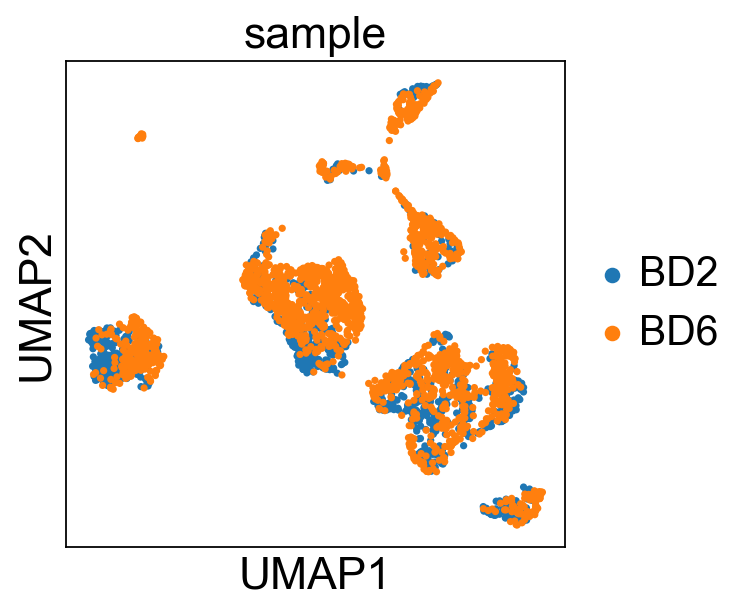

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


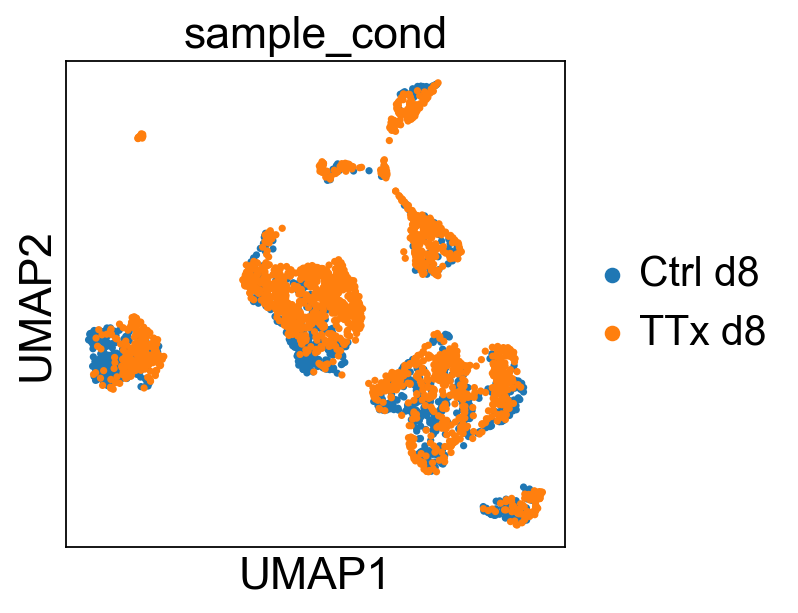

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


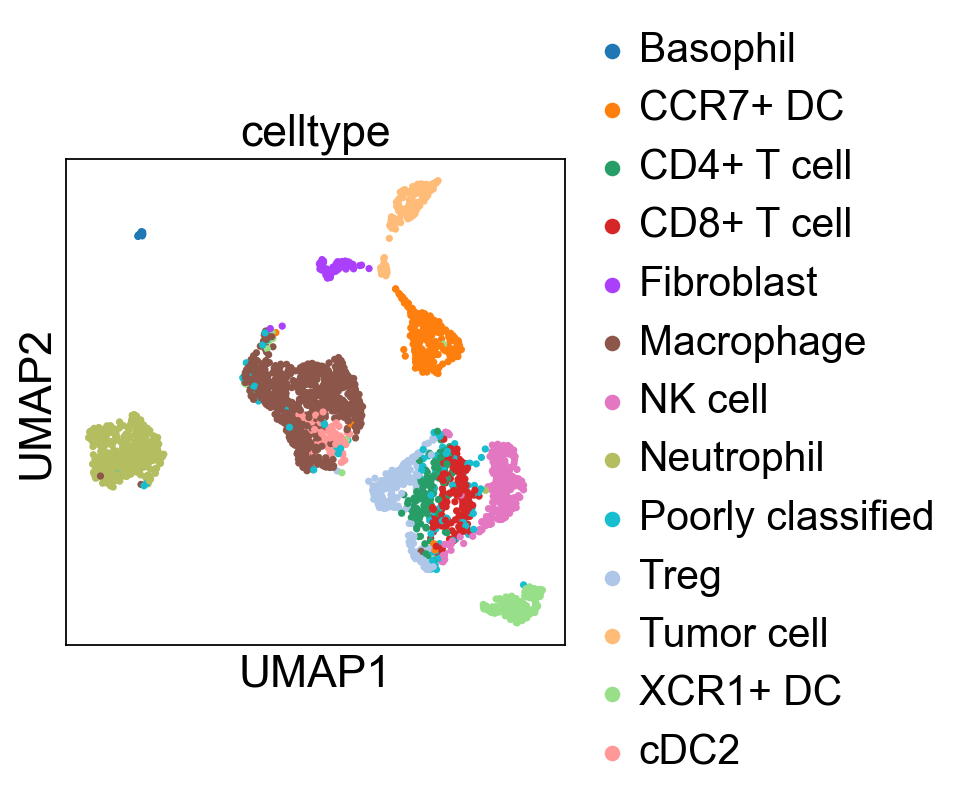

In [75]:
sc.pl.umap(cpi_cd40, color = 'sample')
sc.pl.umap(cpi_cd40, color = 'sample_cond')
sc.pl.umap(cpi_cd40, color = 'celltype')

In [119]:
adata_d8

AnnData object with n_obs × n_vars = 8155 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'sample', 'sample_cond', 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_

In [45]:
adata_d8.obs['replicate'] = encode_replicates(adata_d8, None)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_11913/1356714385.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['sample'][z] == 'BD1':


In [46]:
adata_d8.obs['replicate']

AAACGGGAGCTAGTCT-1-BD2    R4
AAAGATGAGCGATAGC-1-BD2    R4
AAAGCAAGTCACCCAG-1-BD2    R1
AAAGTAGAGAGAACAG-1-BD2    R2
AAAGTAGAGTGGGCTA-1-BD2    R3
                          ..
TTTGTCATCAGTGCAT-1-BD6    R1
TTTGTCATCCCGGATG-1-BD6    R1
TTTGTCATCGACAGCC-1-BD6    R4
TTTGTCATCTAACGGT-1-BD6    R2
TTTGTCATCTGGTTCC-1-BD6    R1
Name: replicate, Length: 8155, dtype: object

In [47]:
adata_d8.obs['sample_rep'] = build_samplerep(adata_d8, 'sample_cond', 'replicate')

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_11913/3057157362.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])


In [48]:
adata_d8.obs['sample_rep']

AAACGGGAGCTAGTCT-1-BD2    Ctrl d8 R4
AAAGATGAGCGATAGC-1-BD2    Ctrl d8 R4
AAAGCAAGTCACCCAG-1-BD2    Ctrl d8 R1
AAAGTAGAGAGAACAG-1-BD2    Ctrl d8 R2
AAAGTAGAGTGGGCTA-1-BD2    Ctrl d8 R3
                             ...    
TTTGTCATCAGTGCAT-1-BD6     TTx d8 R1
TTTGTCATCCCGGATG-1-BD6     TTx d8 R1
TTTGTCATCGACAGCC-1-BD6     TTx d8 R4
TTTGTCATCTAACGGT-1-BD6     TTx d8 R2
TTTGTCATCTGGTTCC-1-BD6     TTx d8 R1
Name: sample_rep, Length: 8155, dtype: object

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


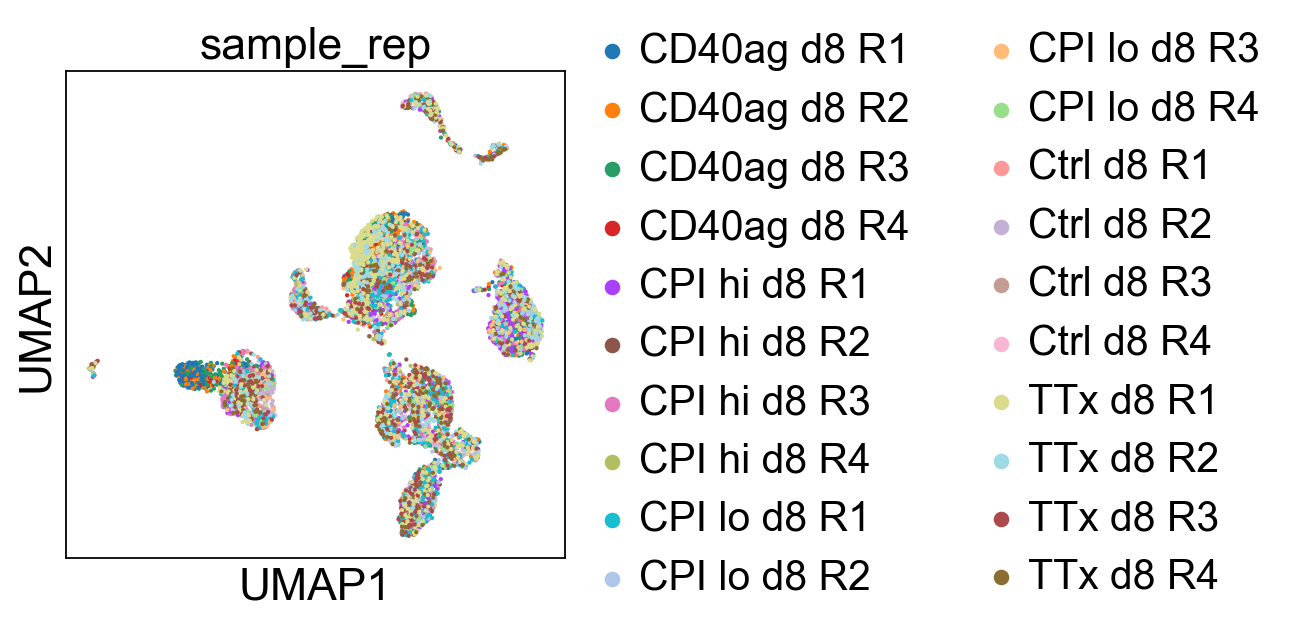

In [49]:
sc.pl.umap(adata_d8, color='sample_rep')

In [50]:
milo.make_nhoods(adata_d8, prop = 0.1)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[47.60197067 65.70249939 38.6943779  27.55219078 44.56929398 44.6019249
 29.62086678 29.87444496 50.12038803 39.25159836 51.14676285 46.91795349
 56.92880249 47.13624954 32.51524734 60.21939087 46.24897766 34.06216049
 53.91973877 32.64168167 41.04214478 38.91481018 33.43085098 30.69597244
 45.83255768 29.27159309 31.15872002 34.2790451  46.60092163 49.57643127
 29.19516182 42.33892059 28.37446976 34.78565979 46.87286377 50.83229828
 34.13696289 46.70358658 36.50174332 29.21775246 32.08049393 31.408638
 54.76267242 38.08724594 28.48992538 50.02651978 28.95484352 36.94431305
 40.76639557 41.94405746 29.39247894 36.72152328 24.73026657 35.69245529
 39.71680832 52.89012146 47.98451614 35.09217072 24.95187569 28.51579475
 38.95599365 39.86153793 32.45190811 35.21926117 31.30164909 27.5

In [51]:
adata_d8.obsm["nhoods"]

<8155x671 sparse matrix of type '<class 'numpy.float32'>'
	with 18884 stored elements in Compressed Sparse Row format>

In [52]:
adata_d8[adata_d8.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AACCATGCATGAAGTA-1-BD2,1,47.601971
AACGTTGTCGAACTGT-1-BD2,1,65.702499
ACGATACAGGGCTTGA-1-BD2,1,38.694378
ACGCCAGAGATGCCTT-1-BD2,1,27.552191
ACGTCAAGTAGGCATG-1-BD2,1,44.569294
...,...,...
TTGCGTCTCCCTCAGT-1-BD6,1,40.272305
TTGGCAACATGGTTGT-1-BD6,1,26.445843
TTTATGCCAGGCTCAC-1-BD6,1,34.340279
TTTGTCATCCCGGATG-1-BD6,1,34.806118


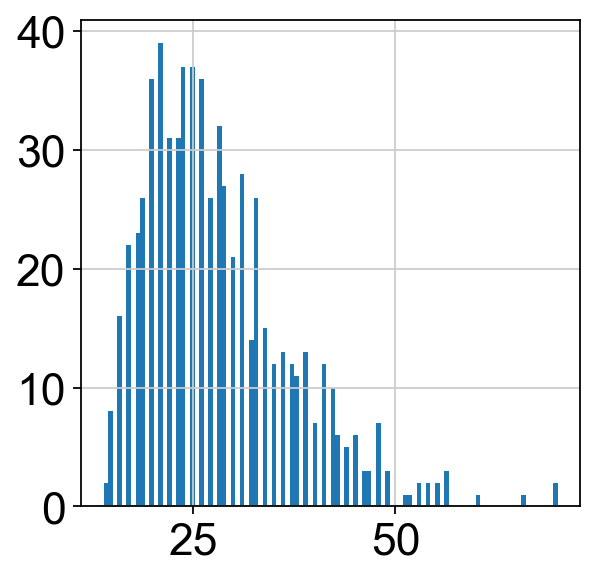

In [53]:
nhood_size = np.array(adata_d8.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [54]:
#milo.count_nhoods(adata, sample_col="sample")
adata_d8.obs['rep_code'] = adata_d8.obs['sample_rep'].cat.codes
milo.count_nhoods(adata_d8, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [55]:
adata_d8.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 671 × 20
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [56]:
milo.DA_nhoods(adata_d8, design="~ sample_cond")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [58]:
milo_results = adata_d8.uns["nhood_adata"].obs

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


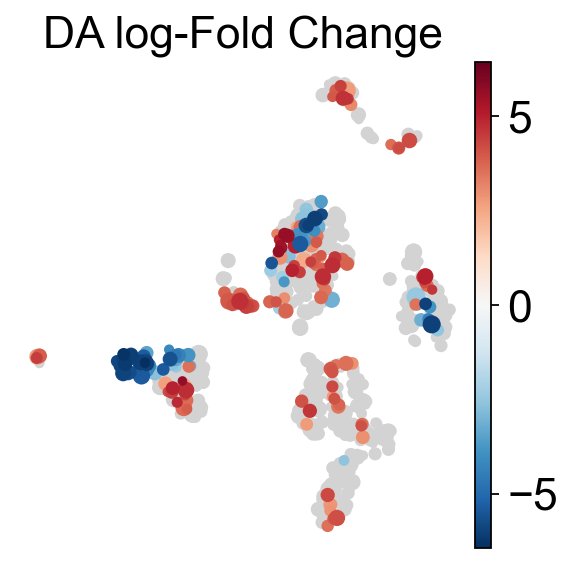

<Figure size 320x320 with 0 Axes>

In [59]:
milopy.utils.build_nhood_graph(adata_d8)
milopy.plot.plot_nhood_graph(adata_d8, alpha=0.1, min_size=5)
plt.tight_layout()

Text(0.5, 0, 'celltype fraction')

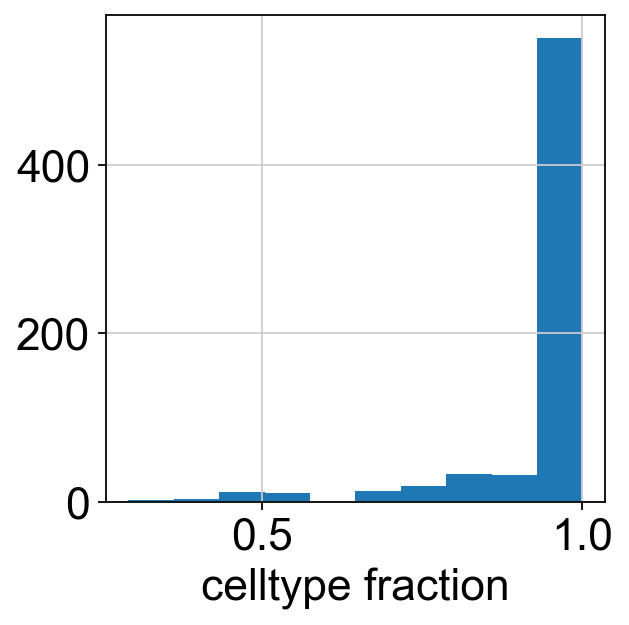

In [61]:
milopy.utils.annotate_nhoods(adata_d8, anno_col='celltype')
plt.hist(adata_d8.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")
#adata_d8.uns['nhood_adata'].obs.loc[adata_d8.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.5, "nhood_annotation"] = "Mixed"

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


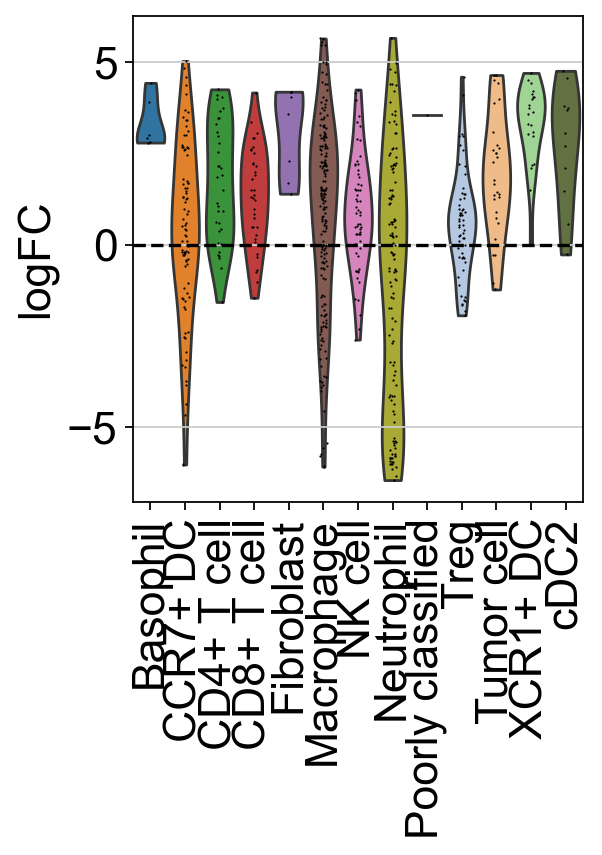

In [62]:
sc.pl.violin(adata_d8.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False, palette=celltype_dict)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [64]:
from community import community_louvain
import networkx as nx

In [68]:
test_adj2 = group_nhoods(adata_d8, 2, 1.5)

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_11913/2046446300.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:


In [69]:
test_adj2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
G_test1 = nx.from_numpy_array(test_adj2)

In [73]:
from distinctipy import distinctipy

In [74]:
partition = community_louvain.best_partition(G_test1)

50


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib

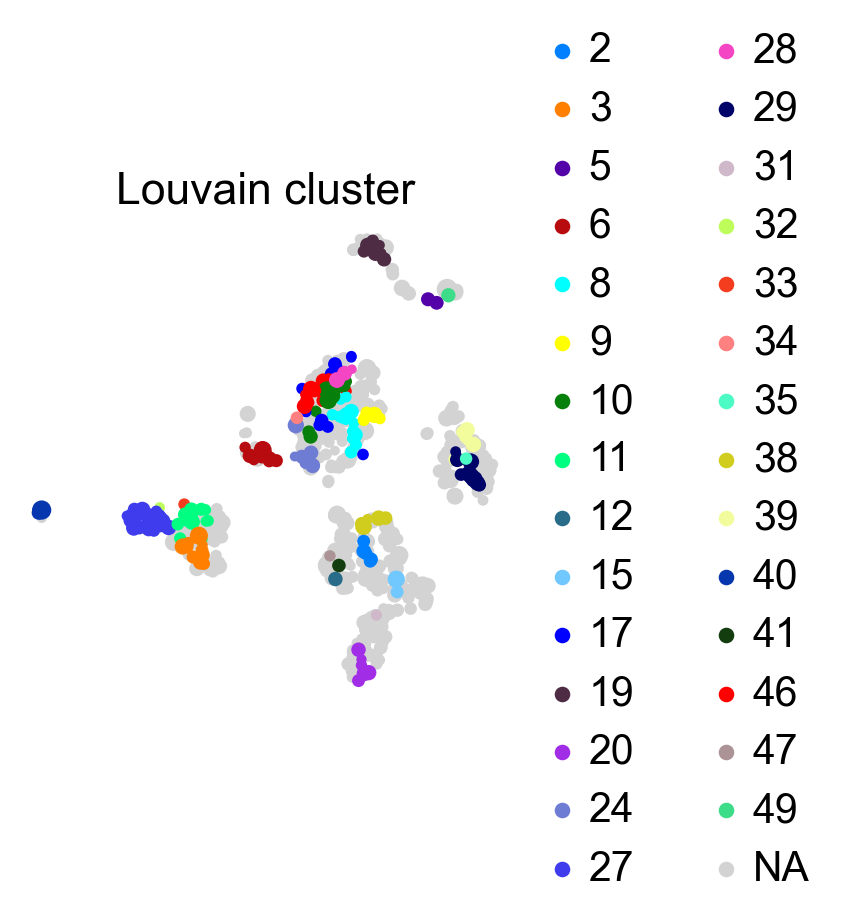

<Figure size 320x320 with 0 Axes>

In [75]:
print(np.max(list(partition.values())))
louvain_lab0, louvain_pal0 = plot_nhood_clusters(adata_d8, list(partition.values()), 'Louvain cluster', alpha=0.1, min_size=5)
plt.tight_layout()

In [77]:
adata_d8.uns['nhood_adata'].obs['louvain'] = louvain_lab0
louvain_order = np.array([2,3,5,6,8,9,10,11,12,15,17,19,20,24,27,28,29,31,32,33,34,35,38,39,40,41,46,47,49])

In [86]:
adata_d8.uns['nhood_adata']

AnnData object with n_obs × n_vars = 671 × 20
    obs: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac', 'louvain'
    var: 'sample_cond', 'rep_code'
    uns: 'sample_col', 'nhood', 'annotation_labels', 'annotation_obs', 'louvain_colors'
    obsm: 'X_milo_graph', 'frac_annotation'
    obsp: 'nhood_connectivities'

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


ValueError: The palette dictionary is missing keys: {'17', '8', '19', '40', '34', '27', '33', '49', '29', '5', '38', '3', '24', '12', '28', '31', '10', '46', '32', '47', '41', '15', '2', '39', '20', '11', '6', '9', '35'}

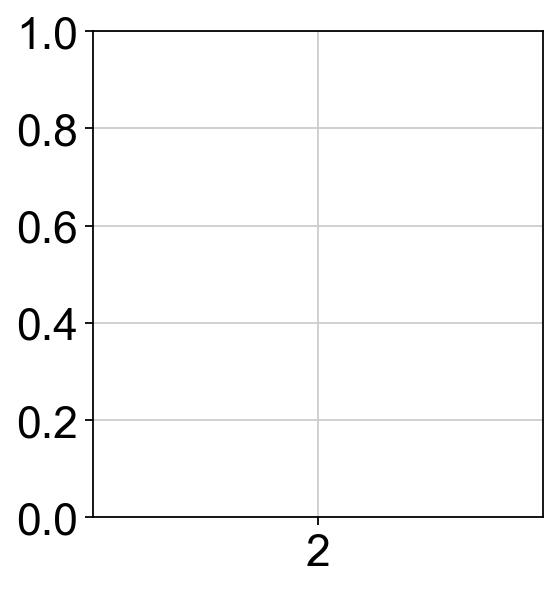

In [87]:
sc.pl.violin(adata_d8.uns['nhood_adata'], "logFC", groupby="louvain", show=False, palette=louvain_pal0,
             order=louvain_order, rotation=45)